In [98]:
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer 
import gensim
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xg

In [2]:
pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore")


In [3]:
train=pd.read_csv('train_E6oV3lV.csv')
test=pd.read_csv('test_tweets_anuFYb8.csv')

# Exploratory Data Analysis(EDA)

In [4]:
# non-racist comments
train[train['label']==0].head() 


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [5]:
#racist comments
train[train['label']==1].head() 


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [6]:
train.shape

(31962, 3)

In [7]:
test.shape

(17197, 2)

In [8]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [9]:
length_train=train['tweet'].str.len()
length_test=test['tweet'].str.len()

<function matplotlib.pyplot.show(close=None, block=None)>

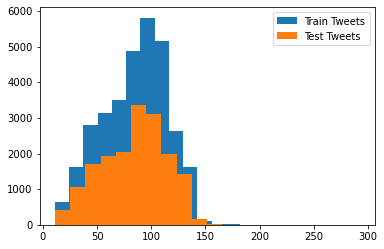

In [10]:
plt.hist(length_train,bins=20,label="Train Tweets")
plt.hist(length_test,bins=20,label="Test Tweets")
plt.legend()
plt.show

# Filtering/Cleaning

In [11]:
combi=train.append(test,ignore_index=True)
combi.shape

(49159, 3)

In [12]:
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    return input_txt

    

In [13]:
combi['tidy_tweet']=np.vectorize(remove_pattern)(combi["tweet"],"@[\w]*")

In [14]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [15]:
combi['tidy_tweet']=combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")

In [16]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [17]:
combi['tidy_tweet']=combi['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

In [18]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


# Text Normalization

In [19]:
tokenized_tweet=combi['tidy_tweet'].apply(lambda x: x.split())

In [20]:
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [21]:
stemmer=PorterStemmer()

In [22]:
tokenized_tweet=tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [23]:
for i in range(len(tokenized_tweet)):
               tokenized_tweet[i]=' '.join(tokenized_tweet[i])
combi['tidy_tweet']=tokenized_tweet                        

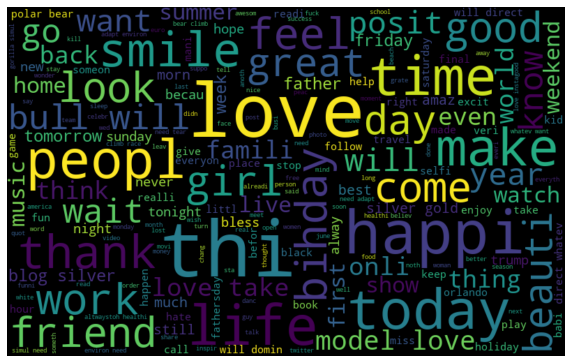

In [24]:
all_words=''.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

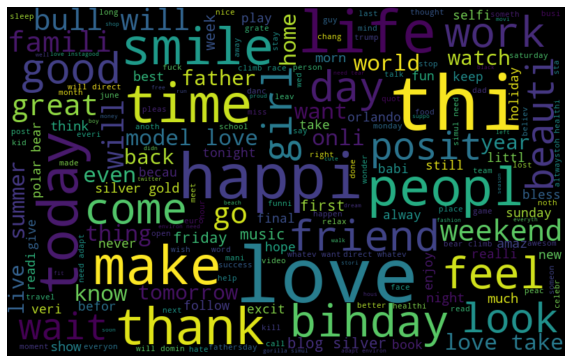

In [25]:
normal_words=''.join([text for text in combi['tidy_tweet'][combi['label']==0]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

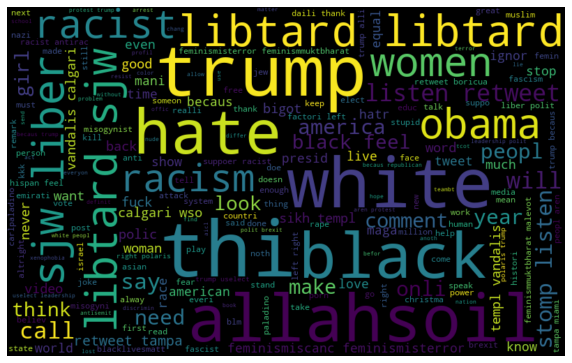

In [26]:
negative_words=''.join([text for text in combi['tidy_tweet'][combi['label']==1]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [27]:
def hashtags_extract(x):
    hashtags=[]
    for i in x:
        ht=re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [28]:
HT_postive=hashtags_extract(combi['tidy_tweet'][combi['label']==0])
HT_negative=hashtags_extract(combi['tidy_tweet'][combi['label']==1])

In [29]:
#un nesting the list 
HT_postive=sum(HT_postive,[])
HT_negative=sum(HT_negative,[])

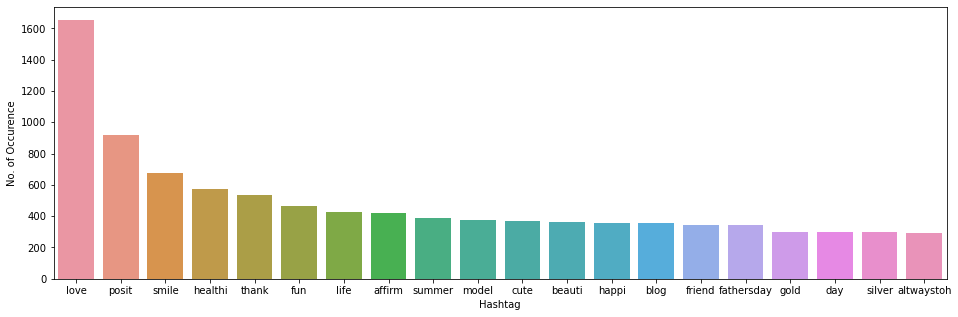

In [30]:
# Non-Racist Tweets
a=nltk.FreqDist(HT_postive)
d=pd.DataFrame({'Hashtag':list(a.keys()),'Count':list(a.values())})
# Top 20 most frequent Hashtags
d=d.nlargest(columns='Count',n=20)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=d,x='Hashtag',y='Count')
ax.set(xlabel='Hashtag',ylabel="No. of Occurence")
plt.show()

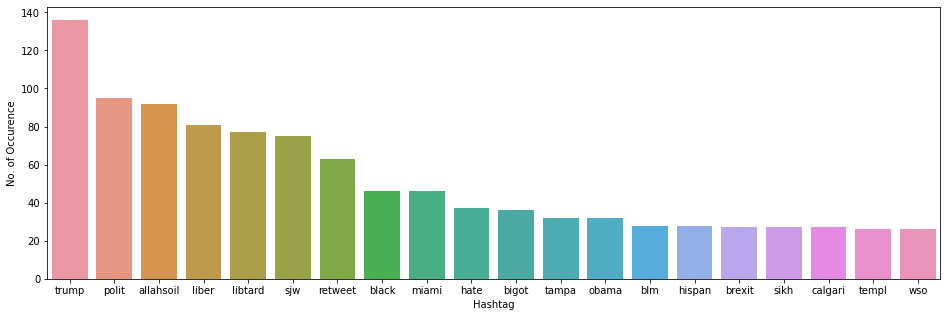

In [31]:
b=nltk.FreqDist(HT_negative)
e=pd.DataFrame({'Hashtag':list(b.keys()),'Count':list(b.values())})
# Top 20 most frequent Hashtags
e=e.nlargest(columns='Count',n=20)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=e,x='Hashtag',y='Count')
ax.set(xlabel='Hashtag',ylabel="No. of Occurence")
plt.show()

# Feature Conversion

## Bag of Words Features

In [32]:
bow_vectorizer=CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
bow=bow_vectorizer.fit_transform(combi['tidy_tweet'])


## TF-IDF

In [33]:
tfidf_vectorizer=TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
tfidf=tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

## Word Embeddings

### Word2Vec Embedding

In [34]:
tokenized_tweet=combi['tidy_tweet'].apply(lambda x: x.split())
model_w2v=gensim.models.Word2Vec(tokenized_tweet,size=200,window=5,min_count=2,sg=1,hs=0,negative=10,workers=2,seed=34)
# sg=1 for skip gram mode
# size for  dezired no. of independent/feature variables
# window for context window size
#workers=no. of cores

In [35]:
model_w2v.train(tokenized_tweet,total_examples=len(combi['tidy_tweet']),epochs=20)

(6510028, 7536020)

In [36]:
model_w2v.wv.most_similar(positive='trump')

[('donald', 0.5564171075820923),
 ('hillari', 0.5505683422088623),
 ('melo', 0.5311787128448486),
 ('phoni', 0.5285495519638062),
 ('endors', 0.5274626612663269),
 ('#delegaterevolt', 0.5273503661155701),
 ('unstabl', 0.5270721912384033),
 ('tomlin', 0.5159137845039368),
 ('jibe', 0.5151537656784058),
 ('unfavor', 0.5095387697219849)]

In [37]:
len(model_w2v['food'])

200

In [38]:
def word_vector(token,size):
    vec=np.zeros(size).reshape((1,size))
    count=0
    for word in token:
        try:
            vec+=model_w2v[word].reshape((1,size))
            count+=1
        except KeyError:
            continue
    if count!=0:
        vec/=count
    return vec

In [39]:
wordvec_arrays=np.zeros((len(tokenized_tweet),200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:]=word_vector(tokenized_tweet[i],200)
wordvec_df=pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

# Modelling

## Logistic Regression

### Bag-of Words Features

In [46]:
train_bow=bow[:31962,:]
test_bow=bow[31962:,:]

In [47]:
xtrain_bow,xvalid_bow,ytrain_bow,yvalid_bow=train_test_split(train_bow,train['label'],random_state=42,test_size=0.3)

In [48]:
lreg=LogisticRegression()

In [49]:
lreg.fit(xtrain_bow,ytrain_bow)

LogisticRegression()

In [50]:
prediction=lreg.predict_proba(xvalid_bow)

In [51]:
prediction_int=prediction[:,1]>=0.3
prediction_int=prediction_int.astype(np.int)

In [52]:
prediction_int.shape

(9589,)

In [53]:
f1_score(yvalid_bow,prediction_int)

0.5303408146300915

In [54]:
test_pred=lreg.predict_proba(test_bow)

In [55]:
testpred_int=test_pred[:,1]>=0.3
testpred_int=testpred_int.astype(np.int)

In [56]:
test['label']=testpred_int

In [57]:
submission=test[['id','label']]
submission.to_csv('sublreg_bow.csv',index=False)

###  TF-IDF 

In [58]:
train_tfidf=tfidf[:31962,:]
test_tfidf=tfidf[31962:,:]

In [59]:
xtrain_tfidf=train_tfidf[ytrain_bow.index]
xvalid_tfidf=train_tfidf[yvalid_bow.index]
xtrain_tfidf.shape

(22373, 1000)

In [60]:
lreg.fit(xtrain_tfidf,ytrain_bow)

LogisticRegression()

In [61]:
prediction_tfidf=lreg.predict_proba(xvalid_tfidf)

In [62]:
predictiontfidf_int=prediction_tfidf[:,1]>=0.3
predictiontfidf_int=predictiontfidf_int.astype(np.int)

In [63]:
f1_score(yvalid_bow,predictiontfidf_int)

0.5451327433628319

In [64]:
test_pred=lreg.predict_proba(test_tfidf)
testpred_int=test_pred[:,1]>=0.3
testpred_int=testpred_int.astype(np.int)
submission=test[['id','label']]
submission.to_csv('sublreg_tfidf.csv',index=False)

### Word2Vec Features

In [65]:
train_w2v=wordvec_df.iloc[:31962,:]
test_w2v=wordvec_df.iloc[31962:,:]
xtrain_w2v=wordvec_df.iloc[ytrain_bow.index,:]
xvalid_w2v=wordvec_df.iloc[yvalid_bow.index,:]

In [66]:
lreg.fit(xtrain_w2v,ytrain_bow)

LogisticRegression()

In [67]:
prediction_w2v=lreg.predict_proba(xvalid_w2v)

In [68]:
predictionw2v_int=prediction_w2v[:,1]>=0.3
predictionw2v_int=predictionw2v_int.astype(np.int)

In [69]:
f1_score(yvalid_bow,predictionw2v_int)

0.621301775147929

In [70]:
test_pred=lreg.predict_proba(test_w2v)
testpred_int=test_pred[:,1]>=0.3
testpred_int=testpred_int.astype(np.int)
submission=test[['id','label']]
submission.to_csv('sublreg_w2v.csv',index=False)

## SVM

### Bag Of Words

In [76]:
svc=svm.SVC(kernel='linear',C=1,probability=True).fit(xtrain_bow,ytrain_bow)

In [77]:
prediction=svc.predict_proba(xvalid_bow)
prediction_int= prediction[:,1]>=0.3
prediction_int=prediction_int.astype(np.int)

In [78]:
f1_score(yvalid_bow,prediction_int)

0.5088207985143919

In [79]:
test_pred=svc.predict_proba(test_bow)
testprediction_int= test_pred[:,1]>=0.3
testprediction_int=testprediction_int.astype(np.int)
test['label']=testprediction_int
submission=test[['id','label']]
submission.to_csv('subsvm_bow.csv',index=False)

### TF-IDF

In [80]:
svc=svm.SVC(kernel='linear',C=1,probability=True).fit(xtrain_tfidf,ytrain_bow)
prediction_tfidfsvm=svc.predict_proba(xvalid_tfidf)
prediction_tfidfsvm_int= prediction_tfidfsvm[:,1]>=0.3
prediction_tfidfsvm_int=prediction_tfidfsvm_int.astype(np.int)
f1_score(yvalid_bow,prediction_tfidfsvm_int)

0.5114155251141552

In [81]:
test_predtfidf=svc.predict_proba(test_tfidf)
testprediction_inttfidf= test_predtfidf[:,1]>=0.3
testprediction_inttfidf=testprediction_inttfidf.astype(np.int)
test['label']=testprediction_inttfidf
submission=test[['id','label']]
submission.to_csv('subsvm_tfidf.csv',index=False)

### Word2Vec

In [82]:
svc=svm.SVC(kernel='linear',C=1,probability=True).fit(xtrain_w2v,ytrain_bow)
prediction_w2vsvm=svc.predict_proba(xvalid_w2v)
prediction_w2vsvm_int= prediction_w2vsvm[:,1]>=0.3
prediction_w2vsvm_int=prediction_w2vsvm_int.astype(np.int)
f1_score(yvalid_bow,prediction_w2vsvm_int)

0.6235201262825572

In [83]:
test_predw2v=svc.predict_proba(test_w2v)
testprediction_intw2v= test_predw2v[:,1]>=0.3
testprediction_intw2v=testprediction_intw2v.astype(np.int)
test['label']=testprediction_intw2v
submission=test[['id','label']]
submission.to_csv('subsvm_w2v.csv',index=False)

## Random Forest

### Bag-of-Words

In [86]:
rd=RandomForestClassifier(n_estimators=400,random_state=11).fit(xtrain_bow,ytrain_bow)
predict=rd.predict(xvalid_bow)
f1_score(yvalid_bow,predict)

0.5529225908372828

In [87]:
test_pred=rd.predict(test_bow)
test['label']=test_pred
submission=test[['id','label']]
submission.to_csv('subrf_bow.csv',index=False)

### TF-IDF

In [88]:
rd=RandomForestClassifier(n_estimators=400,random_state=11).fit(xtrain_tfidf,ytrain_bow)
predicttfidf=rd.predict(xvalid_tfidf)
f1_score(yvalid_bow,predicttfidf)

0.562152133580705

In [89]:
test_predtfidf=rd.predict(test_tfidf)
test['label']=test_predtfidf
submission=test[['id','label']]
submission.to_csv('subrf_tfidf.csv',index=False)

### Word2Vec


In [90]:
rd=RandomForestClassifier(n_estimators=400,random_state=11).fit(xtrain_w2v,ytrain_bow)
predictw2v=rd.predict(xvalid_w2v)
f1_score(yvalid_bow,predictw2v)

0.5174234424498416

In [91]:
test_predw2v=rd.predict(test_w2v)
test['label']=test_predw2v
submission=test[['id','label']]
submission.to_csv('subrf_w2v.csv',index=False)

## XG Boost

### Bag of Words

In [92]:
xgb_model=XGBClassifier(max_depth=6,n_estimators=1000).fit(xtrain_bow,ytrain_bow)
prediction=xgb_model.predict(xvalid_bow)
f1_score(yvalid_bow,prediction)

0.5247706422018349

In [93]:
test_pred=xgb_model.predict(test_bow)
test['label']=test_pred
submission=test[['id','label']]
submission.to_csv('subxgb_bow.csv',index=False)

### TF-IDF

In [94]:
xgb=XGBClassifier(max_depth=6,n_estimators=1000).fit(xtrain_tfidf,ytrain_bow)
prediction_tfidf=xgb.predict(xvalid_tfidf)
f1_score(yvalid_bow,prediction_tfidf)

0.5394265232974911

In [95]:
test_pred_tfidf=xgb.predict(test_tfidf)
test['label']=test_pred_tfidf
submission=test[['id','label']]
submission.to_csv('subxgb_tfidf.csv',index=False)

### Word2Vec

In [96]:
xgb=XGBClassifier(max_depth=6,n_estimators=1000).fit(xtrain_w2v,ytrain_bow)
prediction_w2v=xgb.predict(xvalid_w2v)
f1_score(yvalid_bow,prediction_w2v)

0.6642857142857144

In [97]:
test_pred_w2v=xgb.predict(test_w2v)
test['label']=test_pred_w2v
submission=test[['id','label']]
submission.to_csv('subxgb_w2v.csv',index=False)

# Fine tuning 

In [99]:
dtrain=xg.DMatrix(xtrain_w2v,label=ytrain_bow)
dvalid=xg.DMatrix(xvalid_w2v,label=yvalid_bow)
dtest=xg.DMatrix(test_w2v)

In [ ]:
params=('objective':'binary:logistic','max_depth':6,'min_child_weight':1,)